In [57]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import seaborn as sns
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deass\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deass\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
dataset = pd.read_csv('./data.csv')
dataset.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### a) Análise Exploratória

#### Análise inicial dos dados

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [24]:
# Verificar o número de valores faltantes para cada coluna
valores_faltantes = dataset.isnull().sum()
print(valores_faltantes)

Sentence     0
Sentiment    0
dtype: int64


Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

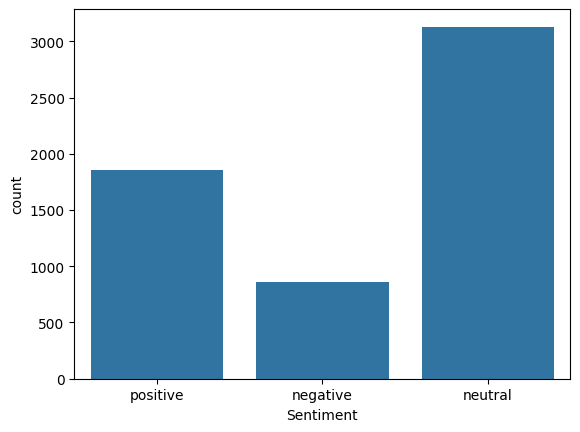

In [25]:
sns.countplot(x='Sentiment', data=dataset)
dataset['Sentiment'].value_counts()

In [26]:
#dataset['novacolumna']=[1,2,3]
#dataset
#tambem pode adicionar uma nova columna assim:
#dataset.insert(2,'nome',[1,2,3],True)

#### Explorando o comprimento dos textos (string)

In [27]:
dataset['length_text'] = dataset['Sentence'].apply(len)
dataset['length_text'].describe()

count    5842.000000
mean      117.020712
std        56.417790
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: length_text, dtype: float64

##### Histograma

<Axes: xlabel='length_text', ylabel='Count'>

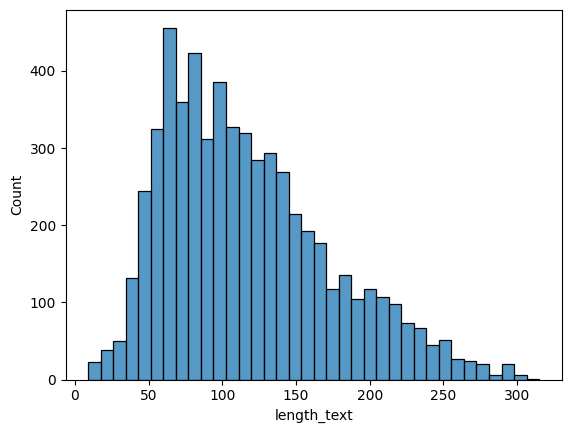

In [28]:
sns.histplot(dataset['length_text'])

##### Boxplot

<Axes: ylabel='length_text'>

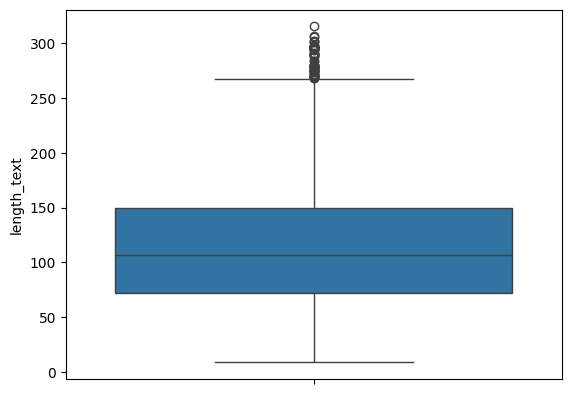

In [29]:
sns.boxplot(dataset['length_text'])

In [30]:
#corr_matrix = dataset['length_text'].corr(dataset['Sentiment'], method='pearson')


# Criando o heatmap
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#plt.title('Heatmap de Correlação')
#plt.show()

In [31]:
dataset_tokens = []
stopwords = nltk.corpus.stopwords.words('english')

for entry in dataset['Sentence']:
    tokens = nltk.tokenize.word_tokenize(entry)
    dataset_tokens.append( [word for word in tokens if word not in stopwords and word.isalpha()] ) 

dataset_tokens[1]

['ESI', 'lows', 'BK', 'real', 'possibility']

In [32]:
# Quantos adjetivos tem  cada linha
nltk.download('averaged_perceptron_tagger')
new_col=[]
for linha in dataset_tokens:
    norm_words=[word.lower() for word in linha if word.isalpha()]
    ps_tagger=nltk.pos_tag(norm_words)
    #print(ps_tagger)
    #for i in ps_tagger:
    #    print(i[1])
    n_adj=len([i for i in ps_tagger if i[1]=='JJ'])
    print(n_adj)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\deass\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


6
2
2
1
3
1
0
2
3
3
0
2
1
0
2
1
1
2
1
1
3
1
3
3
1
1
1
1
5
1
4
5
1
0
1
1
3
1
1
4
3
6
2
3
2
0
1
1
3
0
3
2
0
0
1
0
3
0
2
2
3
0
1
1
2
2
3
0
1
3
1
0
3
4
0
0
0
3
0
3
0
1
6
3
3
3
1
1
1
2
1
1
1
3
2
0
3
5
0
0
2
1
4
0
2
2
1
3
2
7
2
4
2
0
1
1
2
1
1
1
3
1
2
3
2
1
2
2
3
1
4
2
3
2
3
5
4
6
3
2
3
1
1
0
1
3
2
0
2
2
1
2
0
1
1
2
0
0
2
1
0
5
2
2
0
1
0
1
1
2
1
1
3
4
3
0
1
3
2
2
3
2
2
2
1
5
0
4
4
2
2
3
4
0
1
1
2
3
3
2
1
5
1
8
0
1
1
2
4
1
2
3
0
1
2
0
2
0
4
1
3
1
0
1
3
2
1
1
4
4
2
0
0
7
1
2
2
0
6
0
0
1
0
2
0
3
2
0
2
2
3
1
0
4
7
0
3
0
0
3
2
0
1
4
2
0
3
5
1
0
2
1
3
2
1
3
1
1
3
1
2
3
2
2
0
1
2
6
3
3
3
1
3
3
1
2
4
0
0
4
2
1
1
0
0
3
2
2
1
2
3
1
1
2
2
2
5
1
0
5
2
1
2
4
6
0
0
2
1
2
3
0
5
1
1
2
1
0
0
1
2
1
0
2
1
3
0
0
0
1
1
2
4
7
3
4
1
3
1
4
0
1
1
3
1
0
7
0
3
3
0
5
0
2
1
2
0
0
0
1
5
2
1
2
0
1
2
2
3
1
1
2
0
1
1
2
5
1
2
3
1
2
2
4
1
5
2
2
0
3
2
1
2
3
4
2
2
1
0
1
2
1
2
4
2
2
3
6
4
2
5
2
3
0
3
3
4
1
1
0
2
1
0
3
3
1
1
1
4
3
0
2
3
0
0
1
0
1
0
0
3
2
0
1
4
1
1
0
3
2
1
3
4
5
1
1
0
2
1
1
2
1
0
2
1
0
2
3
1
0
2
4
1
0
4
7
5
0
3
1


## b) Tratamento do dados

SVM

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Sentence'], dataset['Sentiment'], test_size=0.2, random_state=42)

In [34]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [35]:
model = svm.SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [36]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="accuracy", 
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.7151411462788708

In [48]:
grid_svm.best_params_

{'svc__C': 1}

In [49]:
grid_svm.best_score_

0.6882121631989374

In [69]:
def report_results(model, X, y):
    # Binarize the output
    y_bin = label_binarize(y, classes=np.unique(y))
    n_classes = y_bin.shape[1]

    pred_proba = model.predict_proba(X)
    pred = model.predict(X)

    if n_classes == 2:
        # Only one class is present
        auc = roc_auc_score(y, pred_proba[:, 1])
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], pred_proba[:, i])
            roc_auc[i] = roc_auc_score(y_bin[:, i], pred_proba[:, i])  # Calculate AUC for each class

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), pred_proba.ravel())
        auc = roc_auc_score(y_bin, pred_proba, multi_class='ovr')

    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average='weighted')
    prec = precision_score(y, pred, average='weighted')
    rec = recall_score(y, pred, average='weighted')
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [70]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8705941451413132,
 'f1': 0.7224743936919779,
 'acc': 0.7151411462788708,
 'precision': 0.7353791655439856,
 'recall': 0.7151411462788708}

In [73]:
def get_roc_curve(model, X, y):
    # Binarize the output
    y_bin = label_binarize(y, classes=np.unique(y))
    n_classes = y_bin.shape[1]

    if n_classes == 2:
        pred_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, pred_proba)
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        for i in range(n_classes):
            pred_proba = model.predict_proba(X)[:, i]
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], pred_proba)
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr, tpr = all_fpr, mean_tpr
    return fpr, tpr


C:\Users\deass\AppData\Local\Temp\ipykernel_24864\1562425951.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


In [74]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

C:\Users\deass\AppData\Local\Temp\ipykernel_24864\1562425951.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


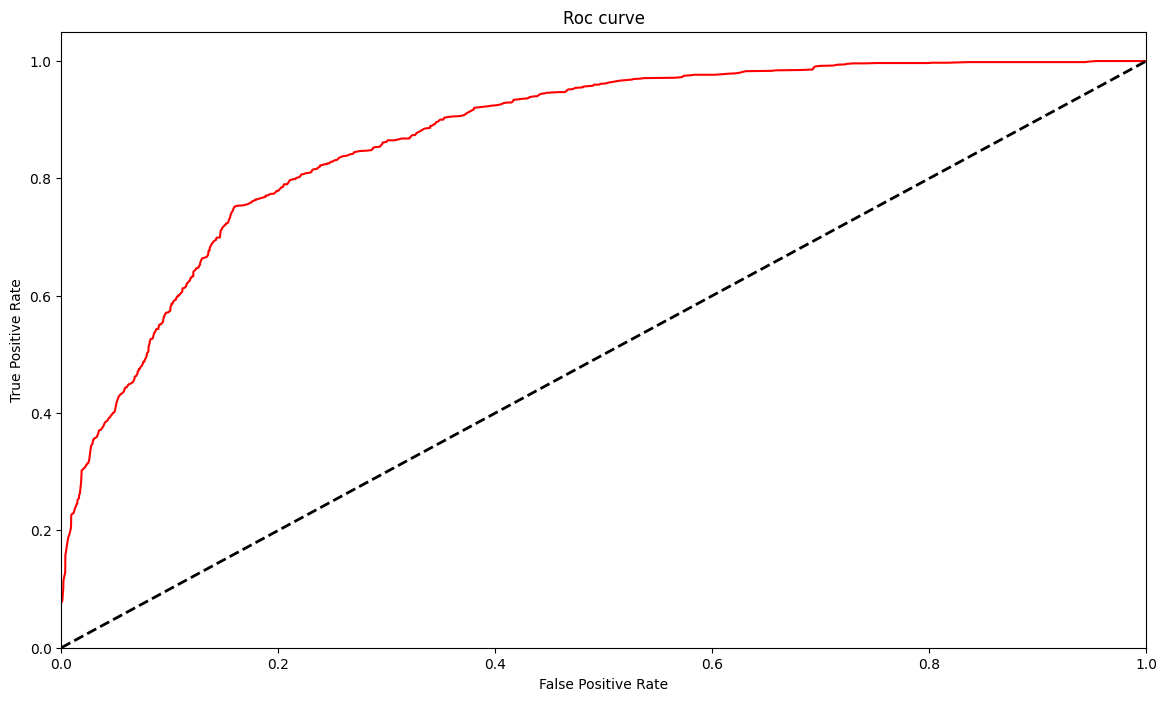

In [88]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [89]:
predictions = model.predict(X_test_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.48      0.17      0.25       175
     neutral       0.72      0.91      0.80       622
    positive       0.78      0.67      0.73       372

    accuracy                           0.72      1169
   macro avg       0.66      0.58      0.59      1169
weighted avg       0.70      0.72      0.69      1169



In [76]:
train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [98]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

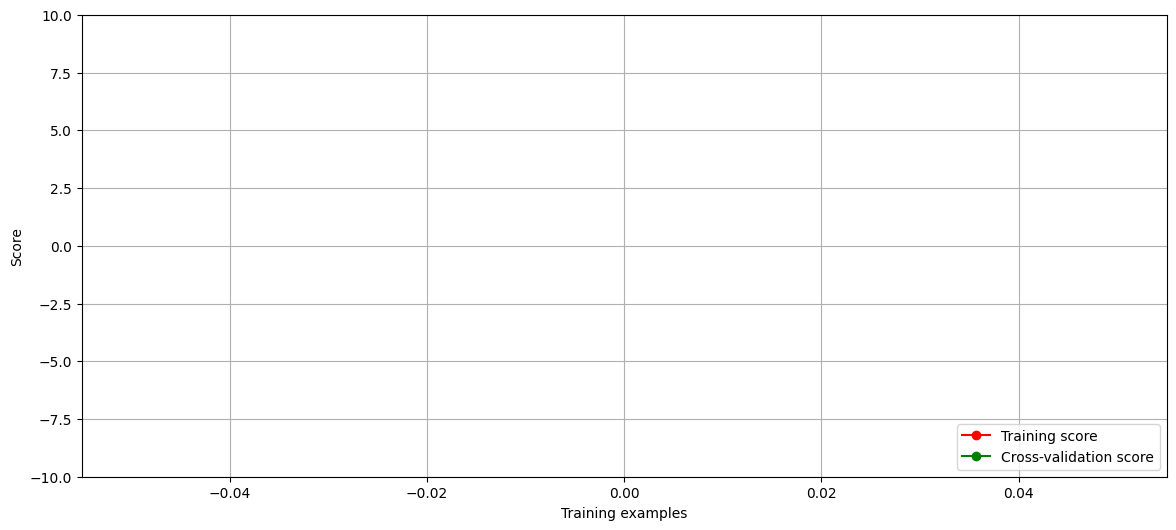

In [97]:
def plot_learning_curve(model, X_train, y_train, title='', ylim=None, figsize=(14,6)):
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="lower right")
    return plt

# Call the function with the correct arguments
plot_learning_curve(svm.SVC(kernel='linear'), X_train, y_train, ylim=(-10, 10.01), figsize=(14,6))
plt.show()

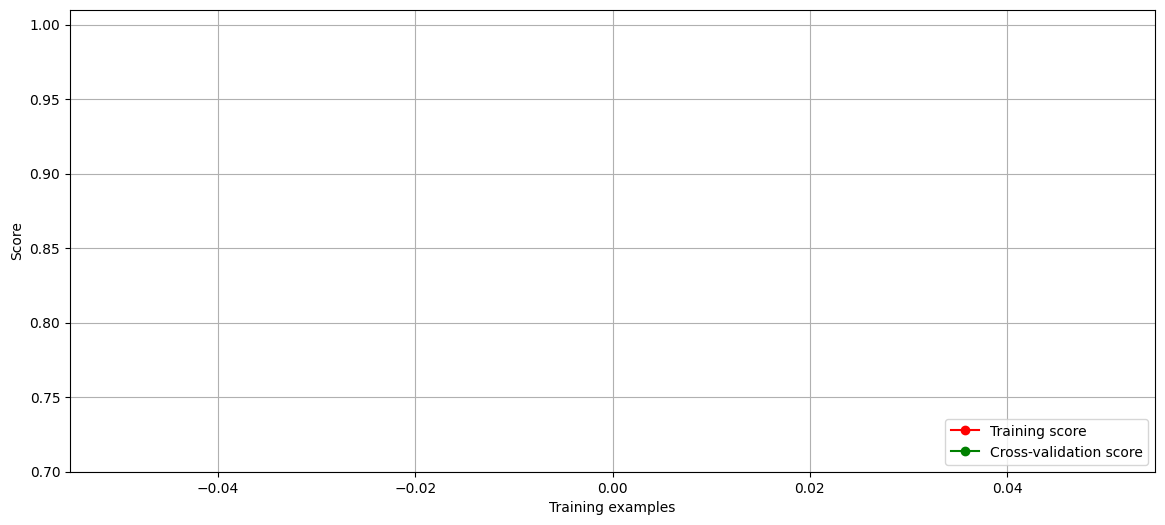

In [99]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()